In [1]:
from fourRoomsEnv import FourRoomsEnv
from dqn_net_larger import CNNCom
from equivariant_dqn_net_larger import EquivariantCNNCom
from memory import ReplayMemory
from utils.schedules import LinearSchedule

import copy
import tqdm
import torch
import numpy as np
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [16]:
class LinearSchedule(object):
    """ This schedule returns the value linearly"""
    def __init__(self, start_value, end_value, duration):
        self._start_value = start_value
        self._end_value = end_value
        self._duration = duration
        self._schedule_amount = end_value - start_value

    def value(self, time):
        # logic: if time > duration, use the end value, else use the scheduled value
        return self._start_value + self._schedule_amount * min(1.0, time * 1.0 / self._duration)

exploration = LinearSchedule(1, .1, 200_000)

In [3]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance
    :param batch: Batch of experiences (class defined earlier)
    :param dqn_model: The DQN model to be trained
    :param dqn_target: The target DQN model, ~NOT~ to be trained
    :param gamma: The discount factor
    :rtype: Float. The scalar loss associated with this batch
    """
  
    values = dqn_model(batch.observations).gather(1, batch.actions)

    with torch.no_grad():
        next_q = dqn_target(batch.next_observations).max(1)[0].view(-1, 1)
        target_values = batch.rewards + gamma * next_q * (~batch.dones)

    loss = F.smooth_l1_loss(values, target_values)  # CHANGED

    optimizer.zero_grad()  # Reset all previous gradients
    loss.backward()  # Compute new gradients
    optimizer.step()  # Perform one gradient-descent step

    return loss.item()

In [37]:
params = {"num_steps": 200_000,
          "num_saves": 5,
          "replay_size": 200_000,
          "replay_prepopulate_steps": 50_000,
          "batch_size": 64,
          "state_size": 2,
          "gamma": 0.99,
          "model": "equi",
          "checkpoint": None,
          "checkpoint_t": 0} # equi or regular 

# # def train_dqn(env, exploration, params):
# env = FourRoomsEnv(rand_seed=123)

# # Initialize the DQN and DQN-target models
# if params["model"] == "regular":
#     dqn_model = CNNCom()
#     dqn_target = CNNCom()#.custom_load(dqn_model.custom_dump())
# else:
#     dqn_model = EquivariantCNNCom()
#     dqn_target = EquivariantCNNCom()
#     dqn_model.train()
#     dqn_target.train()

# if params["checkpoint"] is not None:
#     checkpoint = torch.load(params["checkpoint"])
#     dqn_model.load_state_dict(checkpoint["100_0"]["state_dict"])
#     dqn_target.load_state_dict(checkpoint["100_0"]["state_dict"])
    
# # Initialize the optimizer
# optimizer = torch.optim.Adam(dqn_model.parameters(), lr=1e-3)

# # Initialize the replay memory and prepopulate it
# memory = ReplayMemory(params["replay_size"], len(env.state_space[0]), env.grid.shape)
# memory.populate(env, params["replay_prepopulate_steps"])

# # Initialize lists to store returns, lengths, and losses
# rewards = []
# returns = []
# lengths = []
# losses = []

# # # Initialize structures to store the models at different stages of training
# t_saves = np.linspace(0, params["num_steps"], params["num_saves"] - 1, endpoint=False)
# saved_models = {}

i_episode = 0  # Use this to indicate the index of the current episode
t_episode = 0  # Use this to indicate the time-step inside current episode

state, obs = env.reset()  # Initialize state of first episode
G=0

pbar = tqdm.trange(params["num_steps"])
for t_total in pbar:

    # Save model
    if t_total in t_saves:
        model_name = f'{100 * t_total / params["num_steps"]:04.1f}'.replace('.', '_')
        saved_models[model_name] = copy.deepcopy(dqn_model)

    # get action using e-greedy
    # eps = exploration.value(t_total + params["checkpoint_t"])  # get current epsilon value
    eps = 0.1
    if np.random.rand() < eps:
        action = np.random.choice(env.action_space)
    else:
        with torch.no_grad():
            q_values = dqn_model(torch.tensor(obs, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
            max_q_idx = torch.where(q_values == q_values.max())[0]
            action = np.random.choice(max_q_idx.tolist())
        
    # step forward env
    next_state, next_obs, reward, done = env.step(action)

    # add transition to memory
    memory.add(state, obs, action, reward, next_state, next_obs, done)

    if t_total%4 == 0:
        batch = memory.sample(params["batch_size"])
        loss = train_dqn_batch(optimizer, batch, dqn_model, dqn_target, params["gamma"])
        losses.append(loss)

    if t_total%10000 == 0:
        dqn_target.load_state_dict(dqn_model.state_dict())

    # if t_total%1000 == 0:
    #     eval_reg.append(evaluate(dqn_model, maze_eval_env, 0.1, params["model"]=="equi"))
    #     eval_rot.append(evaluate(dqn_model, maze_rot_eval_env, 0.1, params["model"]=="equi"))

    if done:
        rewards.append(reward)
        G = 0
        for r in rewards[::-1]:
            G = params["gamma"] * G + r

        returns.append(G)
        lengths.append(t_episode)

        pbar.set_description(
            f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G:5.2f} | Epsilon: {eps:4.2f}'
        )

        # reset
        t_episode = 0
        i_episode += 1
        rewards = []
        state, obs = env.reset()
        
    else:
        state = next_state
        obs = np.copy(next_obs)
        t_episode += 1
        rewards.append(reward)

saved_models['100_0'] = copy.deepcopy(dqn_model)

Episode: 133 | Steps: 3731 | Return: -100.00 | Epsilon: 0.10: 100%|███████████| 200000/200000 [1:31:02<00:00, 36.61it/s]


In [36]:
def custom_dump(dqn):
    return {
        # 'args': (2, 9),
        # 'kwargs': {
        #     'num_layers': 3,
        #     'hidden_dim': 1,
        # },
        'state_dict': dqn.state_dict(),
    }

checkpoint = {key: custom_dump(dqn) for key, dqn in saved_models.items()}
torch.save(checkpoint, f'fourrooms_200000_to_400000_steps.pt')

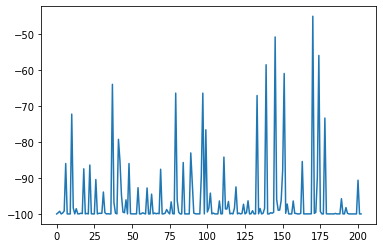

In [18]:
plt.plot(returns)

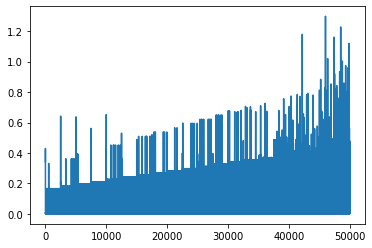

In [19]:
plt.plot(losses)

In [35]:
with open(f"four_room_regular_2000000_run1.npy", "wb") as f:
    np.save(f, np.array(returns))

In [19]:
grid = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                      [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                      [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                      [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                      [1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1],
                      [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                      [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                      [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                      [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
empty_cells = np.where(grid == 0.0)
state_space = [[col, row] for row, col in zip(empty_cells[0], empty_cells[1])]

In [70]:
with open("regular_250000_run5.npy", "wb") as f:
    np.save(f, np.array(eval_reg))
    np.save(f, np.array(eval_rot))
    np.save(f, np.array(returns))

In [108]:
eval_reg = []
eval_rot = []
returns = []
for i in range(1, 6):
    with open(f"regular_250000_run{i}.npy", "rb") as f:
        eval_reg.append(np.load(f))
        eval_rot.append(np.load(f))
        returns.append(np.load(f))

In [133]:
"""Plot function similar to Ex1"""
def plot_curves(arr_list, legend_list, color_list, ylabel):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    plt.clf()
    fig, ax = plt.subplots()

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Episodes")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(0, 1000*arr.shape[1], 1000), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err = 1.96 * arr_err
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.legend(handles=h_list)
    ax.set_title('Evaluated Returns - Rotated Maze')
    plt.show()

In [109]:
min_len = min([len(r) for r in returns_equi])
returns_equi = [r[:min_len] for r in returns_equi]

min_len = min([len(r) for r in returns])
returns = [r[:min_len] for r in returns]

<Figure size 432x288 with 0 Axes>

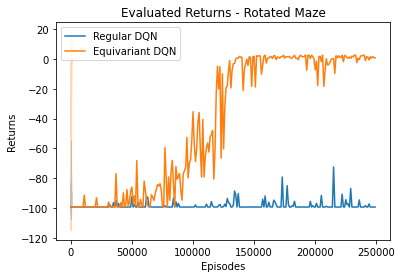

In [134]:
plot_curves([np.array(eval_rot), np.array(eval_rot_equi)], ['Regular DQN', 'Equivariant DQN'], ['C0', 'C1', 'C2', 'C3', 'C4'], 'Returns')

<Figure size 432x288 with 0 Axes>

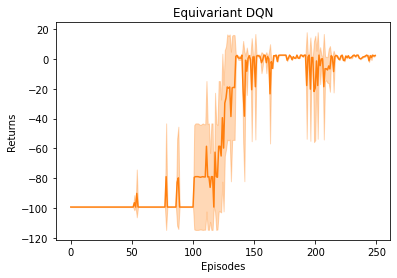

In [123]:
plot_curves([np.array(eval_reg_equi)], 'Equivariant DQN', ['C1', 'C2', 'C3', 'C4'], 'Returns')

In [74]:
def custom_dump(dqn):
    return {
        # 'args': (2, 9),
        # 'kwargs': {
        #     'num_layers': 3,
        #     'hidden_dim': 1,
        # },
        'state_dict': dqn.state_dict(),
    }

checkpoint = {key: custom_dump(dqn) for key, dqn in saved_models.items()}
torch.save(checkpoint, f'dim7_runs250000_4actions_FIXED.pt')

In [32]:
def evaluate(dqn_model, env, eps=0.1, equi=False):
    _, obs = env.reset()
    done = False
    rewards = []
    actions = []
    
    for _ in range(500): # timeout at 500 steps
        # get greedy action
        if np.random.rand() < eps:
            action = np.random.choice(range(4))
        else:
            obs_tensor = torch.tensor(obs.copy(), dtype=torch.float32).unsqueeze(0)
            if equi:
                obs_tensor = obs_tensor.unsqueeze(0)
            q_values = dqn_model(obs_tensor)  # add dim to observation
            max_q_idx = torch.where(q_values == q_values.max())[0]
            action = np.random.choice(max_q_idx.tolist())
    
        _, obs, reward, done = env.step(action)
        rewards.append(reward)

        if done:
            break
    # env.render()
    g = 0
    for r in rewards[::-1]:
        g = 0.99*g + r
    return g

/tmp/ipykernel_542158/3000396438.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("dim7_runs250000_4actions.pt")


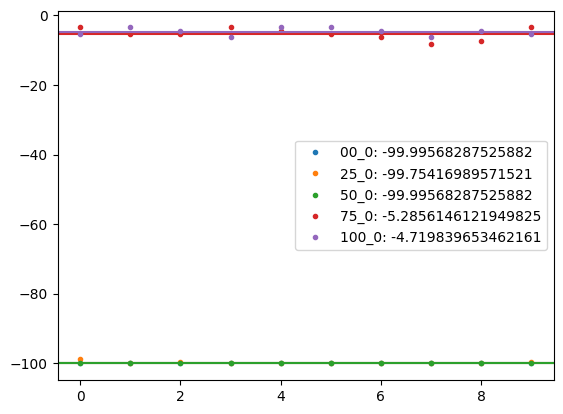

In [103]:
checkpoint = torch.load("dim7_runs25000_4actions.pt")
colors = ['C0', 'C1', 'C2', 'C3', 'C4']
i = 0

for key, value in checkpoint.items():
    dqn = CNNCom()
    dqn.load_state_dict(value["state_dict"])

    g_arr = []
    for _ in range(10):
        g, _ = evaluate(dqn, env, 0.1)
        g_arr.append(g)
    plt.plot(g_arr, '.', color=colors[i], label=f"{key}: {np.mean(g_arr)}")
    plt.axhline(np.mean(g_arr), color=colors[i])
    i += 1

# plt.plot([0, 9], [0.932, .932], 'g', label='optimal rewards')
plt.legend()

In [105]:
x = np.zeros(env.grid.shape)
x[tuple(env.start_state)] = 1

In [118]:
np.argwhere(np.rot90(x, 2))[0]

array([5, 6])

In [106]:
dqn = CNNCom()
dqn.load_state_dict(checkpoint["50_0"]["state_dict"])

<All keys matched successfully>

In [76]:
dqn = CNNCom()

In [17]:
dqn(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0))[0]

tensor(-0.1244, grad_fn=<SelectBackward0>)

In [62]:
rewards = [-1, -1, -1, -1, -1, -1, -1, 1]
g=0
for r in rewards[::-1]:
    g = .99*g + r

In [47]:
maze = MazeEnv(3, 123)
maze_rot = MazeEnv(3, 123, maze.grid, 1)

In [49]:
maze_rot.grid

array([[1. , 1. , 1. , 1. , 1. , 0. , 1. ],
       [1. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [1. , 0. , 1. , 1. , 1. , 0. , 1. ],
       [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
       [1. , 1. , 1. , 0. , 1. , 0. , 1. ],
       [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
       [1. , 0.5, 1. , 1. , 1. , 1. , 1. ]])

In [116]:
env.step(7)
print(env.grid)
x = (dqn_model(torch.tensor(env.grid.copy(), dtype=torch.float32).unsqueeze(0).unsqueeze(0)).reshape(3, 3))
for y in x:
    print(f"{y[0]}\t{y[1]}\t{y[2]}")

[[1.  1.  1.  1.  1.  0.  1. ]
 [1.  0.  0.  0.  0.  0.  1. ]
 [1.  0.  1.  1.  1.  0.  1. ]
 [1.  0.  0.  0.  1.  0.  1. ]
 [1.  1.  1.  0.  1.  0.  1. ]
 [1.  0.  0.  0.  1.  0.5 1. ]
 [1.  0.  1.  1.  1.  1.  1. ]]
0.9423100352287292	2.3529410362243652	1.4532687664031982
1.3097128868103027	1.480532169342041	1.1628659963607788
1.0766695737838745	0.955435574054718	1.4217246770858765


In [22]:
q_values = dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0))  # add dim to observation
max_q_idx = torch.where(q_values == q_values.max())[0]
print((max_q_idx.tolist()))

[7]


In [25]:
x = (dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0)).reshape(3, 3))
for y in x:
    print(f"{y[0]}\t{y[1]}\t{y[2]}")
        

0.8748461008071899	0.8361788988113403	1.5954543352127075
1.667539358139038	1.618808388710022	1.4521780014038086
1.5551992654800415	2.254629373550415	2.3453009128570557


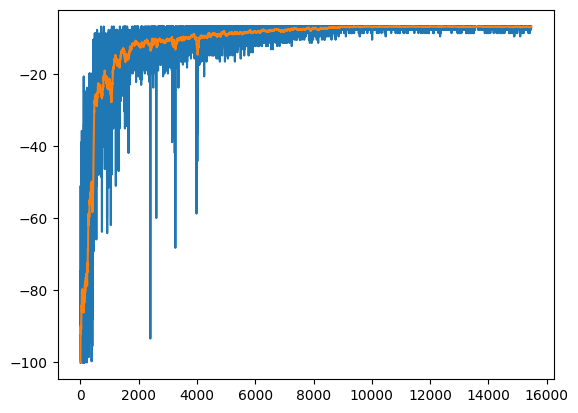

In [7]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))

In [75]:
checkpoint = torch.load("dim7_runs250000_4actions_equi.pt")

/tmp/ipykernel_1963443/2008124539.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("dim7_runs250000_4actions_equi.pt")


In [76]:
dqn = EquivariantCNNCom()
dqn.load_state_dict(checkpoint["100_0"]["state_dict"])
maze = MazeEnv(3, 123)

RuntimeError: Error(s) in loading state_dict for EquivariantCNNCom:
	Missing key(s) in state_dict: "conv.0.expanded_bias", "conv.0.filter", "conv.2.expanded_bias", "conv.2.filter", "conv.4.expanded_bias", "conv.4.filter". 
	Unexpected key(s) in state_dict: "out_layer.0.weight", "out_layer.0.bias", "out_layer.1.weight", "out_layer.1.bias". 
	size mismatch for conv.4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([1]).
	size mismatch for conv.4.weights: copying a param with shape torch.Size([24576]) from checkpoint, the shape in current model is torch.Size([384]).
	size mismatch for conv.4.bias_expansion: copying a param with shape torch.Size([64, 64]) from checkpoint, the shape in current model is torch.Size([1, 1]).

In [5]:
g = [evaluate(dqn, maze, 0.01)[0] for _ in range(20)]

In [6]:
maze_rot = MazeEnv(3, 123, maze.grid, 1)
maze_rot.reset()

([6, 1],
 array([[1. , 1. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 0. , 0. , 1. ],
        [1. , 0. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 1. , 1. , 0. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 0.5, 1. , 1. , 1. , 1. , 1. ]]))

In [7]:
g_rot = [evaluate(dqn, maze_rot, 0.01)[0] for _ in range(20)]

In [8]:
g_rot

[-99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882,
 -99.99568287525882]

In [10]:
# manually evaluate equi dqn
env.reset()

([1, 0],
 array([[1. , 1. , 1. , 1. , 1. , 1. , 1. ],
        [0.5, 0. , 1. , 0. , 0. , 0. , 1. ],
        [1. , 0. , 1. , 0. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 1. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [1. , 1. , 1. , 1. , 1. , 1. , 1. ]]))

In [20]:
env.step(5)

([3, 3],
 array([[1. , 1. , 1. , 1. , 1. , 1. , 1. ],
        [0. , 0. , 1. , 0. , 0. , 0. , 1. ],
        [1. , 0. , 1. , 0. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0.5, 1. , 0. , 1. ],
        [1. , 1. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 0. , 0. , 0. ],
        [1. , 1. , 1. , 1. , 1. , 1. , 1. ]]),
 -1,
 False)

In [21]:
q_values = dqn_model(torch.tensor(env.grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0))  # add dim to observation
max_q_idx = torch.where(q_values == q_values.max())[0]
print((max_q_idx.tolist()))

[1]


In [14]:
q_values

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

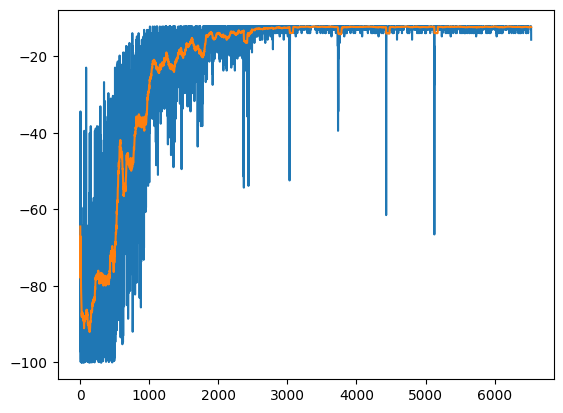

In [62]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))

In [24]:
g_equi = [evaluate(dqn_model, maze, 0.01, True)[0] for _ in range(20)]

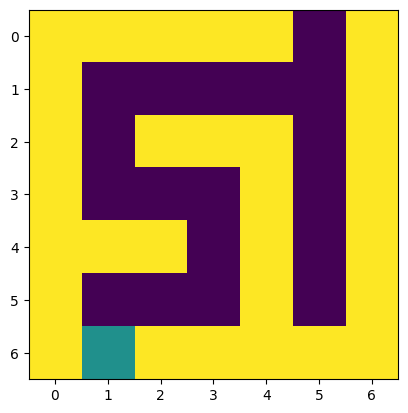

In [39]:
maze_rot.reset()
maze_rot.render()

In [38]:
maze_rot = MazeEnv(3, 123, maze.grid, 1)
maze_rot.reset()
# g_rot_equi = [evaluate(dqn_model, maze_rot, 0.01, True)[0] for _ in range(20)]

([6, 1],
 array([[1. , 1. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 0. , 0. , 1. ],
        [1. , 0. , 1. , 1. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 1. , 1. , 0. , 1. , 0. , 1. ],
        [1. , 0. , 0. , 0. , 1. , 0. , 1. ],
        [1. , 0.5, 1. , 1. , 1. , 1. , 1. ]]))

In [33]:
g_rot_equi

[2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003,
 1.5019163870712111,
 2.5271882697689003,
 0.4868972232004989,
 2.5271882697689003,
 2.5271882697689003,
 2.5271882697689003]

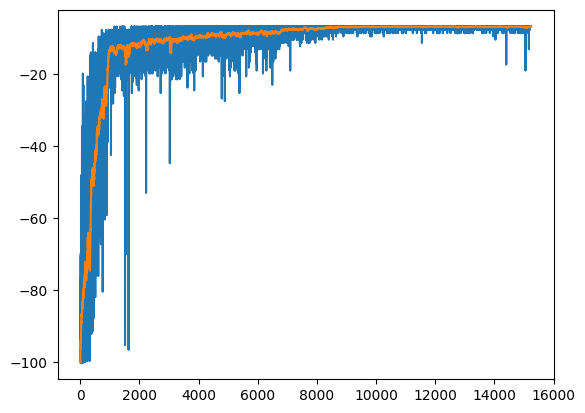

In [9]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    # assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

plt.plot(returns)
plt.plot(moving_average(returns))